# *경찰데이터*

In [1]:
#일반 라이브러리
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#API를 사용하기 위한 import
from geoband.API import *
import folium
import json
import geopandas as gpd

files = ['1.5개시도_경찰서_관할경계.geojson',
            '2.5개시도_치안안전센터_관할경계.geojson',
            '3.체감안전도_설문지.txt',
            '4.체감안전도_통계(2017~2019).csv',
            '5.112신고.csv',
            '6.범죄발생원표.csv',
            '7.범죄검거원표.csv',
            '8.범죄피의자원표.csv',
            '9.5개시도_보안등현황.csv',
            '10.5개시도_CCTV설치현황.csv',
            '11.5개시도_교통사고현황.csv',
            '12.경찰서별_지구대별 인원현황.csv',
            '13.5개시도_화재발생통계.csv',
            '14.5개시도_성연령별_총인구분포.csv',
            '15.5개시도_1인가구수.csv',
            '16.5개시도_인구데이터(외국인).csv',
            '17.5개시도_기초수급자현황.csv',
            '18.5개시도_자살율.csv',
            '19.5개시도_최종학력통계.csv',
            '20.5개시도_공원현황.csv',
            '21.5개시도_유흥업소_단란주점현황.csv',
            '22.5개시도_비상벨현황.geojson',
            '23.5개시도_종관관측기상(2017~2020).csv',
            '24.5개시도_도로명주소(건물).geojson',
            '25.결과제출양식.csv',
            '26.코드정의서.xlsx',
            '27.5개시도_설문결과데이터(2017~2018).csv']

data = dict()

for i in range(len(files)):
    file_name = files[i]
    
    #split
    key,name,lang = file_name.split(".")
    
    #GetCompasData('SBJ_2107_004', key, file_name)
    if lang == "csv":
        data[name] = pd.read_csv(file_name)
    elif lang == "geojson":
        data[name] = gpd.read_file(file_name)
    elif lang == "xlsx":
        data[name] = pd.read_excel(file_name)
    
data["5개시도_치안안전센터_관할경계"].groupby("PSNAME").count()

# 위 2개 데이터를 합치기.
merge_data = pd.merge(data["5개시도_치안안전센터_관할경계"], data["5개시도_경찰서_관할경계"], how = "left", left_on= "PSNAME", right_on="NAME")
merge_data = merge_data.drop("PSNAME", axis = 1)
df = merge_data.groupby(["PNAME", "NAME_y"]).count().reset_index()

police = df[["NAME_y","NAME_x"]]
police.columns = ["경찰서","파출소수"]

# 6번데이터: 5대 범죄 발생횟수
df = data["범죄발생원표"]
df["jur_stn"] = df["jur_stn"].str.lstrip()

df["year"] = ""
df["상반기"] = ""
df.head()

df.crm_date = df.crm_date.astype("str")
temp = df.crm_date.str.split("/")

length = list(map(lambda x: len(x),temp))
date_list = temp.tolist()

# year를 구분하고, 상반기 하반기를 구분함
for idx, l in enumerate(length):
    if l == 1:
        year = date_list[idx][0][:4]
        flag = int(date_list[idx][0][4:6] <= "06")
    else:
        year = date_list[idx][-1]
        flag = int(date_list[idx][0] <= "06")
    
    # 넣기
    temp = [year,flag]
    df.iloc[idx,-2:] = temp
    
    
#df.groupby(["jur_stn","year","상반기","5m_crm_yn"]).count()
df["5m_crm_yn"].replace(" ", np.nan, inplace = True)
df.dropna(subset = ["5m_crm_yn"], inplace = True)

df["vic_sx"].replace("남자", 1, inplace = True)
df["vic_sx"].replace("여자", 2, inplace = True)
df["vic_sx"].replace("불상", 3, inplace = True)

# 수치화
df["vic_sx"] = pd.to_numeric(df["vic_sx"])

# 다른 연도가 있어서 확인

df1 = df.groupby(["jur_stn","year","상반기"])["5m_crm_yn"].count().reset_index()
df1 = df1[df1.year.isin(["2017","2018","2019"])]


# 마산동부, 마산중부, 진해의 상반기 데이터가 빠져 있어서 채워주었다.

a = ["경남마산동부경찰서","경남마산동부경찰서","경남마산동부경찰서","경남마산중부경찰서","경남마산중부경찰서","경남마산중부경찰서","경남진해경찰서","경남진해경찰서","경남진해경찰서"]
b = ["2017","2018","2019"]*3
c = [1]*9
d = [2025,2021,1819,1432,1458,1150,1484,1441,1196]

for i in range(len(a)):
    df1 = df1.append({"jur_stn": a[i],
                "year": b[i],
                "상반기": c[i],
                "5m_crm_yn": d[i]}, ignore_index= True)
    
df1 = df1.sort_values(["jur_stn", "year"])
df1.loc[df1.jur_stn.str[:2].isin(["경기","충남","경남"]), "jur_stn"] = df1.jur_stn.str[2:]

def name_change(df1):
    df1.loc[df1.jur_stn.str[:2].isin(["경기","충남","경남"]), "jur_stn"] = df1.jur_stn.str[2:]
    return df1
df1 = df1.rename(columns= {"jur_stn":"경찰서",
                           "5m_crm_yn": "5대범죄발생건"})

police_5crime = pd.merge(df1,police, how = "inner", on = "경찰서")
police_5crime = police_5crime.rename(columns= {"경찰서":"jur_stn"})

police_5crime.head()

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/opt/app-root/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,jur_stn,year,상반기,5대범죄발생건,파출소수
0,수원남부경찰서,2017,0,3184,9
1,수원남부경찰서,2017,1,2967,9
2,수원남부경찰서,2018,0,3143,9
3,수원남부경찰서,2018,1,2825,9
4,수원남부경찰서,2019,0,2589,9


In [2]:
df = data["범죄검거원표"]
df["date"] =df["date"].astype("str")

df["year"] = df.date.str[:4]
df["상반기"] = (df.date.str[4:] <= "06").astype("int")
df_crime_top5 = df[df["crm"].isin(["폭행","절도","강간","살인","강도"])]

df_crime = df_crime_top5.groupby(["jur_stn","year","상반기"]).count().reset_index()
df_crime = name_change(df_crime)
df_crime[df_crime["year"].isin(["2017","2018","2019"])]
df_crime = df_crime.drop("date", axis = 1)
police2 = pd.merge(police_5crime, df_crime, how = "inner", on = ["jur_stn","year","상반기"])
police2 = police2.rename(columns={"crm":"5대범죄검거건"})


compare1 = data["5개시도_치안안전센터_관할경계"]["PSNAME"].unique().tolist()

df = data["경찰서별_지구대별 인원현황"]
compare2 = df["pol_office"].unique().tolist()

def compare(a,b):
    return [x for x in a if x not in b]

police_list = compare(compare2, compare1)

# 전부다 구로경찰서로 넘기면 됌.
df.loc[df["pol_office"].isin(police_list),"pol_office"] = "서울구로경찰서"

num = df.groupby("pol_office")["num"].sum().reset_index()
num = num.rename(columns= {"pol_office":"jur_stn",
                          "num":"경찰관수"})

police3 = pd.merge(police2,num, how= "inner", on = "jur_stn")
police3["5대범죄검거율"] =  police3["5대범죄검거건"]/police3["5대범죄발생건"]

police3 = police3[['jur_stn', 'year', '상반기', '파출소수', '경찰관수','5대범죄발생건', '5대범죄검거건','5대범죄검거율']]
police3.sort_values(["5대범죄검거율"])



,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율
21,마산동부경찰서,2018,1,7,185,2021,411,0.203365
19,마산동부경찰서,2017,1,7,185,2025,412,0.203457
18,마산동부경찰서,2017,0,7,185,2025,415,0.204938
20,마산동부경찰서,2018,0,7,185,2021,428,0.211776
23,마산동부경찰서,2019,1,7,185,1819,396,0.217702
...,...,...,...,...,...,...,...,...
202,서울용산경찰서,2019,0,7,343,1200,788,0.656667
4,수원남부경찰서,2019,0,9,395,2589,1725,0.666280
154,서울서부경찰서,2019,0,4,221,571,387,0.677758
142,서울방배경찰서,2019,0,4,141,342,239,0.698830


# *개인/사회 데이터*

In [3]:
df = data["5개시도_성연령별_총인구분포"]

# 중구와 강서구에 있었던 중복문제 해결
df = df.drop_duplicates(["sgg_nm", "age", "date"], keep = "first")



date_list = df["date"].unique().tolist()
sgg_list = df["sgg_nm"].unique().tolist()
age_list = []

for age in df["age"].unique().tolist():
    if '~' in age:
        age_list.append(age)
age_list.remove("15~64세")
        
features = ["popu_num","popu_male_num","popu_female_num","local_num","local_male_num","local_female_num"]

# 숫자인지 판별하는 함수
def is_numeric(num):
    num = num.tolist()[0]
    if num.isnumeric():
        return int(num)
    else:
        return 0
#1) date (2017 ~ 2019)
def solve():
    ans = pd.DataFrame(index = range(0,0), columns= df.columns.tolist())
    #1) date
    for year in date_list:
        df_year = df[df["date"] == year]
        #2) sgg
        for sgg in sgg_list:
#             if sgg == "중구" or sgg == "강서구":
#                 continue
            df_sgg = df_year[df_year["sgg_nm"] == sgg]
            
            temp = df_sgg[df_sgg["age"] == "합계"]
            ans = pd.concat([ans, temp])
            
            #3) age
            for i in range(0,len(age_list),2):
                df1 = df_sgg[df_sgg["age"] == age_list[i]]
                df2 = df_sgg[df_sgg["age"] == age_list[i+1]]
                
                # features
                for feature in features:             
                    df1[feature] = is_numeric(df1[feature]) + is_numeric(df2[feature])
                
                
                ans = pd.concat([ans,df1])
    return ans

                        
population = solve()

def make_population(city,year):
    df_city_year = population[(population["sgg_nm"] == city) & (population["date"] == year)]
    total = df_city_year[df_city_year["age"] == "합계"]
    ans = total.iloc[:,:8]
    ans = ans.astype({"popu_num":"int",
                "popu_male_num":"int",
                "popu_female_num":"int",
                "popu_sx_rate":"float"})

    # 0대 ~ 50대 계산
    for i in range(1,7):
        part = df_city_year.iloc[i,:8]
        part["age"] = part.age[:2].rstrip("~") + "대"
        part["popu_sx_rate"] = round(part["popu_male_num"] / part["popu_female_num"] * 100, 1)
        part = pd.DataFrame(part)
        part = part.transpose()
        ans = pd.concat([ans,part])

    # 60대 ~ 90대 덧셈
    temp = df_city_year.iloc[7,:8] + df_city_year.iloc[8,:8] + df_city_year.iloc[9,:8]  + df_city_year.iloc[10,:8]
    temp["sido"] = ans["sido"].unique().item()
    temp["sgg_nm"] = city
    temp["age"] = "60대"
    temp["date"] = year
    temp["popu_sx_rate"] = round(temp["popu_male_num"] / temp["popu_female_num"]*100,1)

    ans = pd.concat([ans,pd.DataFrame(temp).transpose()])
    ans.index = [i for i in range(len(ans))]
    return ans

dong = df["sgg_nm"].unique().tolist()
police_office = data["5개시도_치안안전센터_관할경계"]["PSNAME"].unique().tolist()

dong_poice = {"중구":["서울중부경찰서","서울남대문경찰서"],
             "강서구": ["서울강서경찰서"],
             "종로구": ["서울종로경찰서","서울혜화경찰서"],
             "용산구": ["서울용산경찰서"],
             "성동구":["서울성동경찰서"],
             "광진구":["서울광진경찰서"],
             "동대문구":["서울동대문경찰서"],
             "중랑구":["서울중랑경찰서"],
             "성북구":["서울성북경찰서","서울종암경찰서"],
             "강북구":["서울강북경찰서"],
             "도봉구":["서울도봉경찰서"],
             "노원구":["서울노원경찰서"],
             "은평구":["서울은평경찰서","서울서부경찰서"],
             "서대문구":["서울서대문경찰서"],
             "마포구":["서울마포경찰서"],
             "양천구":["서울양천경찰서"],
             "구로구":["서울구로경찰서"],
             "금천구":["서울금천경찰서"],
             "영등포구":["서울영등포경찰서"],
             "동작구":["서울동작경찰서"],
             "관악구":["서울관악경찰서"],
             "서초구":["서울서초경찰서","서울방배경찰서"],
             "강남구":["서울강남경찰서","서울수서경찰서"],
             "송파구":["서울송파경찰서"],
             "강동구":["서울강동경찰서"],
             "세종시":["세종경찰서"],
             "진주시":["진주경찰서"],
             "창원시의창구":["창원서부경찰서"],
             "창원시성산구":["창원중부경찰서"],
             "창원시마산합포구":["마산중부경찰서"],
             "창원시마산회원구":["마산동부경찰서"],
             "창원시진해구":["진해경찰서"]}
result = pd.DataFrame(index = range(0,0), columns= ["jur_stn", "year", "상반기","전체인구","전체성비","0대 비율","10대 비율", "20대 비율","30대 비율","40대 비율", "50대 비율", "60대 비율"])

years = [2017,2018,2019]
for i in range(len(years)):
    year = years[i]
    for k,v in dong_poice.items():

        temp = make_population(k,year)    
        # popu_num
        value = temp.loc[(temp["age"] == "합계"),"popu_num"].item()
        # 비율
        test = pd.DataFrame(temp.loc[1:, "popu_num"] / value).transpose()
        test["전체인구"] = value
        test["전체성비"] = temp.loc[0,"popu_sx_rate"]
        test["year"] = year
        test.index = [0]
        test.columns = ["0대 비율","10대 비율", "20대 비율","30대 비율","40대 비율", "50대 비율", "60대 비율","전체인구","전체성비","year"]

        for i in range(len(v)):
            test["전체인구"] = int(value/ len(v))
            test["jur_stn"] = v[i]

            test2 = pd.concat([test,test])
            test2["상반기"] = [0,1]

            test2 = test2[["jur_stn", "year", "상반기","전체인구","전체성비","0대 비율","10대 비율", "20대 비율","30대 비율","40대 비율", "50대 비율", "60대 비율"]]

            result = pd.concat([result, test2])
            
# 수원시추가
Suwon = ["수원시팔달구","수원시장안구","수원시권선구","수원시영통구"]
year = 2017

def make_suwon(year):
    t1 = make_population(Suwon[0],year)
    t2 = make_population(Suwon[1],year)
    t3 = make_population(Suwon[2],year)
    t4 = make_population(Suwon[3],year)

    # 덧셈 완료
    ans1 = t1.iloc[:,4:].add(t2.iloc[:,4:])
    ans2 = t3.iloc[:,4:].add(t4.iloc[:,4:])
    ans3 = ans1.add(ans2)

    # 성비다시 계산
    ans3["popu_sx_rate"] = list(map(lambda x: round(x,1), ans3["popu_male_num"] / ans3["popu_female_num"]*100))

    # column 추가
    ans3["sido"] = "경기도"
    ans3["sgg_nm"] = "수원시"
    ans3["date"] = year
    ans3["age"] = t1.age

    #출력 (column 순서변경)
    ans3 = ans3[t1.columns.tolist()]
    return ans3

years = [2017,2018,2019]

temp_result = pd.DataFrame(index = range(0,0), columns =["jur_stn","year", "상반기","전체인구","전체성비","0대 비율","10대 비율", "20대 비율","30대 비율","40대 비율", "50대 비율", "60대 비율"])

for year in years:
    ans3 = make_suwon(year)
    value = ans3.loc[0,"popu_num"]
    test = pd.DataFrame(ans3.loc[1:,"popu_num"] / value).transpose()
    test["전체인구"] = value
    test["전체성비"] = ans3.loc[0,"popu_sx_rate"]
    test["year"] = year
    test.index = [0]
    test.columns = ["0대 비율","10대 비율", "20대 비율","30대 비율","40대 비율", "50대 비율", "60대 비율","전체인구","전체성비","year"]
    test["전체인구"] = int(value/ 3)
    test2 = pd.concat([test,test])
    test2["상반기"] = [0,1]
    test3 = pd.concat([test2,test2,test2])
    test3["jur_stn"] = ["수원남부경찰서","수원남부경찰서","수원서부경찰서","수원서부경찰서","수원중부경찰서","수원중부경찰서"]
    test3 = test3[["jur_stn","year", "상반기","전체인구","전체성비","0대 비율","10대 비율", "20대 비율","30대 비율","40대 비율", "50대 비율", "60대 비율"]]
    temp_result = pd.concat([temp_result, test3])
    
# result    
result = pd.concat([result,temp_result])
result["year"] = result["year"].astype("int")
result["상반기"] = result["상반기"].astype("int")
police3["year"] = police3["year"].astype("int")
police4 = pd.merge(police3, result, how = "inner", on = ["jur_stn","year","상반기"])
police4= police4.astype({"전체인구":"int",
                "0대 비율":"float",
               "10대 비율":"float",
               "20대 비율":"float",
               "30대 비율":"float",
               "40대 비율":"float",
               "50대 비율":"float",
               "60대 비율":"float"})

police4.head()

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율,전체인구,전체성비,0대 비율,10대 비율,20대 비율,30대 비율,40대 비율,50대 비율,60대 비율
0,수원남부경찰서,2017,0,9,395,3184,1417,0.445038,405665,102.4,0.094836,0.107075,0.153747,0.166349,0.178181,0.159016,0.140755
1,수원남부경찰서,2017,1,9,395,2967,1426,0.480620,405665,102.4,0.094836,0.107075,0.153747,0.166349,0.178181,0.159016,0.140755
2,수원남부경찰서,2018,0,9,395,3143,1378,0.438435,406281,102.3,0.091022,0.103279,0.154689,0.163175,0.174214,0.163713,0.149864
3,수원남부경찰서,2018,1,9,395,2825,1374,0.486372,406281,102.3,0.091022,0.103279,0.154689,0.163175,0.174214,0.163713,0.149864
4,수원남부경찰서,2019,0,9,395,2589,1725,0.666280,404995,102.3,0.087293,0.100326,0.154875,0.158340,0.171669,0.167190,0.160250


# *외국인추가*

In [4]:
df = data["5개시도_인구데이터(외국인)"]
df2 = df[["sgg","foreigner_all(2017)", "foreigner_all(2018)", "foreigner_all(2019)"]]


foreign = pd.DataFrame(index = range(0,0), columns = ["jur_stn","year","상반기","외국인수"])

for sgg in df2.sgg.tolist(): # 도시
    if sgg.find("수원") != -1:
        continue
    t = "".join(sgg.split())
    
    police_list = dong_poice[t] #경찰서별
    for police in police_list:
        
        df3 = df2[(df2["sgg"] == sgg)].iloc[:,1:] / len(police_list)
        df3 = df3.transpose()
        df3.columns = ["num"]
        value_list = df3["num"].tolist()*2
        value_list.sort()
        df4 = pd.concat([df3,df3])
        df4["num"] = value_list
        df4 = df4.reset_index()
        df4["index"] = [2017,2017,2018,2018,2019,2019]
        df4["상반기"] = [0,1,0,1,0,1]
        
        df4.columns = ["year","외국인수","상반기"]
        df4["jur_stn"] = police
        df5 = df4[["jur_stn","year","상반기","외국인수"]]
        foreign = pd.concat([foreign, df5])
# 수원시 데이터
df_suwon = df2[df2["sgg"].isin(['수원시 장안구','수원시 권선구','수원시 팔달구','수원시 영통구'])]
suwon_foreign = (df_suwon.sum()[1:] /3).astype("int").tolist()
suwon_foreign = suwon_foreign*2
suwon_foreign.sort()
years = [2017,2017, 2018,2018,2019,2019]
halfs = [0,1,0,1,0,1]

suwon_police = ["수원남부경찰서","수원서부경찰서","수원중부경찰서"]

suwon = pd.DataFrame(index = range(0,0), columns = foreign.columns)
for police in suwon_police:
    temp = pd.DataFrame(suwon_foreign)
    temp.columns = ["외국인수"]
    temp["year"] = years
    temp["상반기"] = halfs
    temp["jur_stn"] = police
    
    temp = temp[foreign.columns.tolist()]
    suwon = pd.concat([suwon,temp])

# 합치기(foreign + suwon_foreign)
foreign = pd.concat([foreign, suwon])
foreign = foreign.astype({"외국인수":"int"})


# 완전합치기
police5 = pd.merge(police4, foreign, how = "inner", on = ["jur_stn","year","상반기"])
police5["외국인비율"] = police5["외국인수"] / police5["전체인구"]
police5.head()



,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율,전체인구,전체성비,0대 비율,10대 비율,20대 비율,30대 비율,40대 비율,50대 비율,60대 비율,외국인수,외국인비율
0,수원남부경찰서,2017,0,9,395,3184,1417,0.445038,405665,102.4,0.094836,0.107075,0.153747,0.166349,0.178181,0.159016,0.140755,16197,0.039927
1,수원남부경찰서,2017,1,9,395,2967,1426,0.480620,405665,102.4,0.094836,0.107075,0.153747,0.166349,0.178181,0.159016,0.140755,16197,0.039927
2,수원남부경찰서,2018,0,9,395,3143,1378,0.438435,406281,102.3,0.091022,0.103279,0.154689,0.163175,0.174214,0.163713,0.149864,17896,0.044048
3,수원남부경찰서,2018,1,9,395,2825,1374,0.486372,406281,102.3,0.091022,0.103279,0.154689,0.163175,0.174214,0.163713,0.149864,17896,0.044048
4,수원남부경찰서,2019,0,9,395,2589,1725,0.666280,404995,102.3,0.087293,0.100326,0.154875,0.158340,0.171669,0.167190,0.160250,18728,0.046243


# 최종학력

In [5]:
df = data["5개시도_최종학력통계"]
df = df[df["age"] == "합계"]
sgg_list = df["sgg_nm"].unique()
edu_list = df["inv_edu"].unique()
ans = pd.DataFrame(index = range(0,0), columns= ["sgg"] + edu_list.tolist())


# 도시별로 총합
for sgg in sgg_list:
    temp = []
    temp.append(sgg)
    for edu in edu_list:
        df_temp = df[(df["sgg_nm"] == sgg) & (df["inv_edu"] == edu)]
        if edu == "계":
            temp.append(int(df_temp["num_in_2015"].sum()))
        else:
            temp.append(df_temp["num_in_2015"].sum()/temp[1])
    ans.loc[len(ans)] = temp

sgg_list = ans["sgg"].tolist() # 행정구역정보
education = pd.DataFrame(index = range(0,0), columns = ans.columns)
for sgg in sgg_list:
    if sgg.find("수원") != -1:
        continue
    
    t = "".join(sgg.split())
    police_list = dong_poice[t]
    for police in police_list:
        test = ans[ans["sgg"] == sgg]
        test["sgg"] = police
        education = pd.concat([education, test])
        
education = education.rename(columns= {"sgg":"jur_stn"})

# 수원
suwon_police = ["수원남부경찰서","수원서부경찰서","수원중부경찰서"]

df_suwon = ans[ans["sgg"].isin(['수원시장안구','수원시권선구','수원시팔달구','수원시영통구'])]

for i in range(4):
    df_suwon.iloc[i,2:] = df_suwon.iloc[i,2:] * df_suwon.iloc[i,1]

temp = pd.DataFrame((df_suwon.sum()[1:] / 3).astype("int")).transpose()
temp.loc[:,"초등학교":]  = temp.loc[:,"초등학교":] / int(temp["계"])

temp2 = pd.concat([temp,temp,temp])
temp2["jur_stn"] = suwon_police
temp2["jur_stn"]

temp3 = pd.concat([temp2["jur_stn"], temp2.loc[:,:"jur_stn"]], axis = 1)
temp3 = temp3.iloc[:,:-1]

temp3.head()

education = pd.concat([education, temp3])
police6 = pd.merge(police5, education, how = "inner", on = "jur_stn")
police6

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:1758: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율,전체인구,전체성비,...,외국인수,외국인비율,계,초등학교,중학교,고등학교,"대학교(2,3년제)",대학교(4년제 이상),대학원(석박사 과정),받지 않았음(미취학 포함)
0,수원남부경찰서,2017,0,9,395,3184,1417,0.445038,405665,102.4,...,16197,0.039927,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521
1,수원남부경찰서,2017,1,9,395,2967,1426,0.480620,405665,102.4,...,16197,0.039927,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521
2,수원남부경찰서,2018,0,9,395,3143,1378,0.438435,406281,102.3,...,17896,0.044048,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521
3,수원남부경찰서,2018,1,9,395,2825,1374,0.486372,406281,102.3,...,17896,0.044048,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521
4,수원남부경찰서,2019,0,9,395,2589,1725,0.666280,404995,102.3,...,18728,0.046243,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,세종경찰서,2017,1,7,178,606,200,0.330033,276589,101.5,...,5290,0.019126,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652
242,세종경찰서,2018,0,7,178,793,257,0.324086,312374,101.4,...,6486,0.020764,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652
243,세종경찰서,2018,1,7,178,662,216,0.326284,312374,101.4,...,6486,0.020764,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652
244,세종경찰서,2019,0,7,178,629,297,0.472178,338136,101.3,...,7829,0.023153,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652


/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54028 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52272 missing from current

<AxesSubplot:>

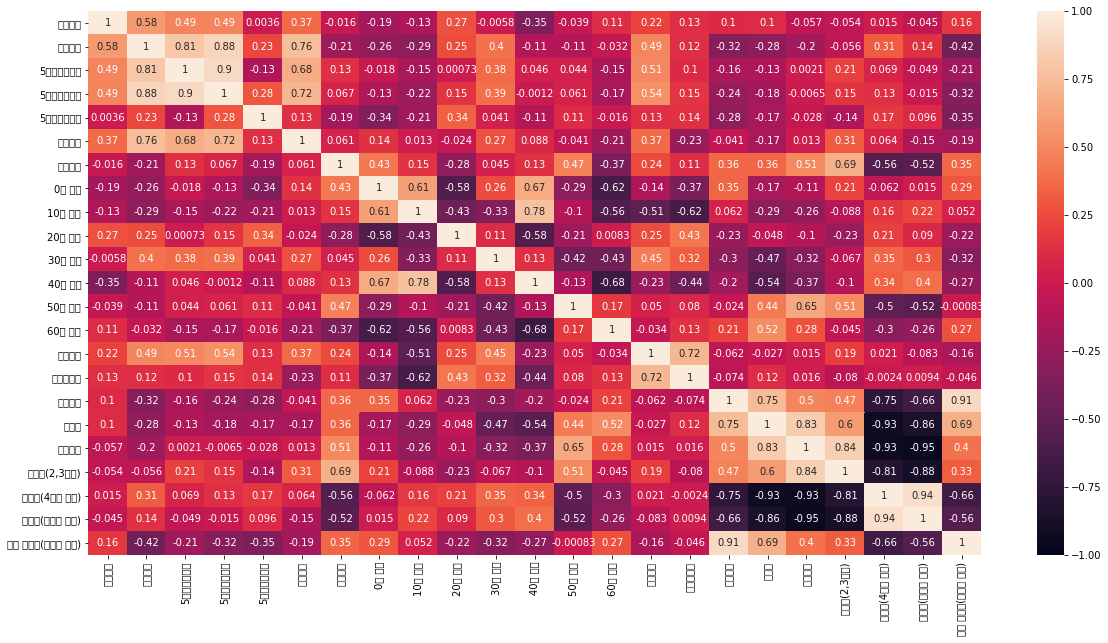

In [6]:

plt.figure(figsize = (20,10))
sns.heatmap(police6.corr(), annot = True, vmin= -1, vmax= 1)

In [7]:
police6["1인당 담당인구수"] = (police6["전체인구"] / police6["경찰관수"]).astype("int")
police6

,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율,전체인구,전체성비,...,외국인비율,계,초등학교,중학교,고등학교,"대학교(2,3년제)",대학교(4년제 이상),대학원(석박사 과정),받지 않았음(미취학 포함),1인당 담당인구수
0,수원남부경찰서,2017,0,9,395,3184,1417,0.445038,405665,102.4,...,0.039927,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1027
1,수원남부경찰서,2017,1,9,395,2967,1426,0.480620,405665,102.4,...,0.039927,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1027
2,수원남부경찰서,2018,0,9,395,3143,1378,0.438435,406281,102.3,...,0.044048,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1028
3,수원남부경찰서,2018,1,9,395,2825,1374,0.486372,406281,102.3,...,0.044048,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1028
4,수원남부경찰서,2019,0,9,395,2589,1725,0.666280,404995,102.3,...,0.046243,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,세종경찰서,2017,1,7,178,606,200,0.330033,276589,101.5,...,0.019126,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1553
242,세종경찰서,2018,0,7,178,793,257,0.324086,312374,101.4,...,0.020764,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1754
243,세종경찰서,2018,1,7,178,662,216,0.326284,312374,101.4,...,0.020764,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1754
244,세종경찰서,2019,0,7,178,629,297,0.472178,338136,101.3,...,0.023153,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1899


# 추가데이터: 기초수급자

In [8]:
df = data["5개시도_기초수급자현황"]
df.date = df.date.astype("str")
df["상반기"] = (df.date.str[4:] <= "06").astype("int")
df["year"] = df.date.str[:4]

df[(df["year"] == "2019") & (df["sgg_nm"] == "강북구") & (df["상반기"] == 1)]["num"].sum()

98496

In [9]:
df_basic = df.groupby(["year","상반기","sgg_nm"])["num"].sum().reset_index()
#df_basic[df_basic["sgg_nm"] == "강동구"]
dong = df_basic["sgg_nm"].unique().tolist()
dong

['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '세종특별자치시',
 '송파구',
 '수원시',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구',
 '진주시',
 '창원시']

In [10]:
dong_police2 = {"중구":["서울중부경찰서","서울남대문경찰서"],
             "강서구": ["서울강서경찰서"],
             "종로구": ["서울종로경찰서","서울혜화경찰서"],
             "용산구": ["서울용산경찰서"],
             "성동구":["서울성동경찰서"],
             "광진구":["서울광진경찰서"],
             "동대문구":["서울동대문경찰서"],
             "중랑구":["서울중랑경찰서"],
             "성북구":["서울성북경찰서","서울종암경찰서"],
             "강북구":["서울강북경찰서"],
             "도봉구":["서울도봉경찰서"],
             "노원구":["서울노원경찰서"],
             "은평구":["서울은평경찰서","서울서부경찰서"],
             "서대문구":["서울서대문경찰서"],
             "마포구":["서울마포경찰서"],
             "양천구":["서울양천경찰서"],
             "구로구":["서울구로경찰서"],
             "금천구":["서울금천경찰서"],
             "영등포구":["서울영등포경찰서"],
             "동작구":["서울동작경찰서"],
             "관악구":["서울관악경찰서"],
             "서초구":["서울서초경찰서","서울방배경찰서"],
             "강남구":["서울강남경찰서","서울수서경찰서"],
             "송파구":["서울송파경찰서"],
             "강동구":["서울강동경찰서"],
             "세종특별자치시":["세종경찰서"],
             "진주시":["진주경찰서"],
             "창원시":["창원서부경찰서","창원중부경찰서","마산중부경찰서","마산동부경찰서","진해경찰서"],
              "수원시":["수원남부경찰서","수원서부경찰서","수원중부경찰서"]}

In [11]:
Basic = pd.DataFrame(index = range(0,0), columns = df_basic.columns)
for sgg in dong:
    police_list = dong_police2[sgg]
    temp = df_basic.loc[df_basic["sgg_nm"] == sgg,:] # 해당하는 DF
    
    if len(police_list) == 1:
        temp["sgg_nm"] = police_list[0]
        Basic = pd.concat([Basic,temp])
    else:
        for policer in police_list:
            temp["num"] = (temp["num"] /len(police_list)).astype("int")
            temp["sgg_nm"] = policer
            Basic = pd.concat([Basic,temp])
            temp = df_basic.loc[df_basic["sgg_nm"] == sgg,:] 

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [12]:
# 2017 ~2019년 까지의 데이터
Basic = Basic.loc[Basic.year.isin(["2017","2018","2019"]),:]
Basic = Basic.rename(columns = {"sgg_nm": "jur_stn",
                        "num":"기초생활자수"})

Basic = Basic.astype({"year":"int",
              "상반기":"int",
             "기초생활자수":"int"})
Basic.dtypes

year        int64
상반기         int64
jur_stn    object
기초생활자수      int64
dtype: object

In [13]:
police7 = pd.merge(police6, Basic, how = "inner", on = ["jur_stn", "year","상반기"])

In [14]:
police7["기초생활자수"] = police7["기초생활자수"] / police7["전체인구"]

In [15]:
police7.sort_values("기초생활자수")

,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율,전체인구,전체성비,...,계,초등학교,중학교,고등학교,"대학교(2,3년제)",대학교(4년제 이상),대학원(석박사 과정),받지 않았음(미취학 포함),1인당 담당인구수,기초생활자수
139,서울방배경찰서,2017,1,4,141,481,231,0.480249,207275,91.6,...,389692,0.081998,0.054843,0.164299,0.076958,0.438662,0.169329,0.013911,1470,0.022555
157,서울서초경찰서,2017,1,7,339,1745,848,0.485960,207275,91.6,...,389692,0.081998,0.054843,0.164299,0.076958,0.438662,0.169329,0.013911,611,0.022555
241,세종경찰서,2017,1,7,178,606,200,0.330033,276589,101.5,...,182967,0.159663,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1553,0.027369
1,수원남부경찰서,2017,1,9,395,2967,1426,0.480620,405665,102.4,...,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1027,0.028378
7,수원서부경찰서,2017,1,7,258,1759,849,0.482661,405665,102.4,...,348781,0.110760,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1572,0.028378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,서울강북경찰서,2018,0,9,347,1764,912,0.517007,309138,94.3,...,301584,0.133833,0.119771,0.348676,0.125594,0.213552,0.031951,0.026623,890,0.295599
113,서울노원경찰서,2019,1,8,415,2074,917,0.442141,522480,93.6,...,531568,0.115152,0.096469,0.284600,0.119328,0.311232,0.050919,0.022300,1258,0.298157
112,서울노원경찰서,2019,0,8,415,1638,927,0.565934,522480,93.6,...,531568,0.115152,0.096469,0.284600,0.119328,0.311232,0.050919,0.022300,1258,0.308458
71,서울강북경찰서,2019,1,9,347,1891,880,0.465362,303871,93.8,...,301584,0.133833,0.119771,0.348676,0.125594,0.213552,0.031951,0.026623,875,0.324138


# 외부데이터: 세금 (2020년도 존재함)

In [16]:
tax = pd.DataFrame(index = range(0,0), columns = ["기간","자치구별","계"])

In [17]:
# 서울시 데이터

import re
reports = ["2017report.txt","2018report.txt","2019report.txt"]
for report in reports:
    df_tax = pd.read_table(report)
    df_tax = df_tax.iloc[2:,:3]
    total_tax = df_tax["계"].str[:].tolist()
    total_tax = list(map(lambda x : re.sub(",","",x), total_tax))

    df_tax["계"] = total_tax
    df_tax = df_tax.astype({"계":"int"})
    df_tax.index = range(len(df_tax))
    tax = pd.concat([tax, df_tax.iloc[2:,]])
tax.head()

,기간,자치구별,계
2,2017,종로구,828034
3,2017,중구,1307220
4,2017,용산구,789772
5,2017,성동구,546315
6,2017,광진구,407932


In [18]:
# 수원시
suwon = [1794740,1704835,1528677]

# 창원시
chang = [1399322,1257777,1331373]

# 세종시
sejong = [666939,670652,665142]

# 진주시
jinju = [391361,379248,378908]

taxes = [suwon, chang, sejong, jinju]
names = ["수원시","창원시","세종특별자치시","진주시"]

In [19]:
residual = pd.DataFrame(index = range(0,0), columns = tax.columns)
for i in range(4):
    test = pd.DataFrame(taxes[i])
    test["자치구별"] = names[i]
    test["기간"] = [2017,2018,2019]
    test = test.rename(columns= {0:"계"})
    test = test[residual.columns]
    residual = pd.concat([residual, test])
    
residual.head()
tax = pd.concat([tax, residual])

In [20]:
# tax를 경찰서 버전으로 바꿔주기
df_basic = tax
Basic = pd.DataFrame(index = range(0,0), columns = df_basic.columns)
for sgg in dong: # dong정보는 위에서 가져옴
    police_list = dong_police2[sgg] #위에서 나옴
    temp = df_basic.loc[df_basic["자치구별"] == sgg,:] # 해당하는 DF
    
    if len(police_list) == 1:
        temp["자치구별"] = police_list[0]
        Basic = pd.concat([Basic,temp])
    else:
        for policer in police_list:
            temp["계"] = (temp["계"] /len(police_list)).astype("int")
            temp["자치구별"] = policer
            Basic = pd.concat([Basic,temp])
            temp = df_basic.loc[df_basic["자치구별"] == sgg,:]

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [21]:
Basic.columns = ["year","jur_stn","지방세징수액"]

In [22]:
result_tax = pd.concat([Basic,Basic])
result_tax = result_tax.astype({"year": "int"})
result_tax = result_tax.sort_values(["year","jur_stn"])
result_tax["상반기"] = [0,1]*3*41
result_tax.head()

,year,jur_stn,지방세징수액,상반기
0,2017,마산동부경찰서,279864,0
0,2017,마산동부경찰서,279864,1
0,2017,마산중부경찰서,279864,0
0,2017,마산중부경찰서,279864,1
24,2017,서울강남경찰서,1401459,0


In [23]:
police8 = pd.merge(police7, result_tax, how = 'inner', on = ["jur_stn","year","상반기"])

In [24]:
police8.sort_values("지방세징수액").head()

,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율,전체인구,전체성비,...,초등학교,중학교,고등학교,"대학교(2,3년제)",대학교(4년제 이상),대학원(석박사 과정),받지 않았음(미취학 포함),1인당 담당인구수,기초생활자수,지방세징수액
153,서울서부경찰서,2018,1,4,221,671,338,0.503726,231276,93.5,...,0.114368,0.095306,0.323850,0.123840,0.272904,0.045767,0.023964,1046,0.196713,189132
152,서울서부경찰서,2018,0,4,221,751,362,0.482024,231276,93.5,...,0.114368,0.095306,0.323850,0.123840,0.272904,0.045767,0.023964,1046,0.209183,189132
206,서울은평경찰서,2018,0,5,203,1121,510,0.454951,231276,93.5,...,0.114368,0.095306,0.323850,0.123840,0.272904,0.045767,0.023964,1139,0.209183,189132
207,서울은평경찰서,2018,1,5,203,1122,522,0.465241,231276,93.5,...,0.114368,0.095306,0.323850,0.123840,0.272904,0.045767,0.023964,1139,0.196713,189132
168,서울성북경찰서,2017,0,6,252,899,439,0.488320,222708,93.4,...,0.120439,0.099752,0.278906,0.108492,0.305617,0.064723,0.022072,883,0.162805,195417


# 1인가구 데이터

In [25]:
sgg_list = ["종로구"
,"중구"
,"용산구"
,"성동구"
,"광진구"
,"동대문구"
,"중랑구"
,"성북구"
,"강북구"
,"도봉구"
,"노원구"
,"은평구"
,"서대문구"
,"마포구"
,"양천구"
,"강서구"
,"구로구"
,"금천구"
,"영등포구"
,"동작구"
,"관악구"
,"서초구"
,"강남구"
,"송파구"
,"강동구"
,"세종특별자치시"
,"수원시"
,"진주시"
,"창원시"]

sgg_list2 = [sgg for sgg in sgg_list for i in range(3) ]


In [26]:
family1 =[0.37898416,0.397127311,0.393778331
        ,0.386224333, 0.391755489,0.405130652
        ,0.363065575,0.370162162,0.377217554
        ,0.322982548,0.328372176,0.33793272
        ,0.371102363,0.37877433,0.391674727
        ,0.371866698,0.378250575,0.391994553
        ,0.298946773,0.308616191,0.324650445
        ,0.313592295,0.320664406,0.327235485
        ,0.307052899,0.320436531,0.334273349
        ,0.233929223,0.244270941,0.257452831
        ,0.242738538,0.253452349,0.264893923
        ,0.259044427,0.269596003,0.285650928
        ,0.342759252,0.352170256,0.36109146
        ,0.354430877,0.366832322,0.377652421
        ,0.204190194,0.211702121,0.223157546
        ,0.294456263,0.309691458,0.330526579
        ,0.275344309,0.282593529,0.29767175
        ,0.345407055,0.358927496,0.380385642
        ,0.346647782,0.356915458,0.378202088
        ,0.33958716,0.35215951,0.364251378
        ,0.460204468,0.476146832,0.494986661
        ,0.255296985,0.264686201,0.274603062
        ,0.302716414,0.308873712,0.319928919
        ,0.247764361,0.260528769,0.273028246
        ,0.255476724,0.264555714,0.277267819
        ,0.301672658,0.300456191,0.301378949
        ,0.280728663,0.28750341,0.30032732
        ,0.302666502,0.305450855,0.312703421
        ,0.267084763,0.271138567,0.279844569]



In [27]:
family1 = pd.DataFrame(family1)
family1["jur_stn"] = sgg_list2
years = [2017,2018,2019]*29
family1["year"] = years
family1 = family1.rename(columns= {0:"1인가구비율"})
family1.head()

,1인가구비율,jur_stn,year
0,0.378984,종로구,2017
1,0.397127,종로구,2018
2,0.393778,종로구,2019
3,0.386224,중구,2017
4,0.391755,중구,2018


In [28]:
# family1를 경찰서 버전으로 바꿔주기
df_basic = family1
Basic = pd.DataFrame(index = range(0,0), columns = family1.columns)
for sgg in dong: # dong정보는 위에서 가져옴
    police_list = dong_police2[sgg] #위에서 나옴
    temp = df_basic.loc[df_basic["jur_stn"] == sgg,:] # 해당하는 DF
    
    if len(police_list) == 1:
        temp["jur_stn"] = police_list[0]
        Basic = pd.concat([Basic,temp])
    else:
        for policer in police_list:
            temp["1인가구비율"] = (temp["1인가구비율"] /len(police_list)).astype("float")
            temp["jur_stn"] = policer
            Basic = pd.concat([Basic,temp])
            temp = df_basic.loc[df_basic["jur_stn"] == sgg,:]
            
            

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [29]:
result_family1 = pd.concat([Basic,Basic])
result_family1 = result_family1.astype({"year": "int"})
result_family1 = result_family1.sort_values(["year","jur_stn"])
result_family1["상반기"] = [0,1]*3*41
result_family1.head()

,1인가구비율,jur_stn,year,상반기
84,0.053417,마산동부경찰서,2017,0
84,0.053417,마산동부경찰서,2017,1
84,0.053417,마산중부경찰서,2017,0
84,0.053417,마산중부경찰서,2017,1
66,0.151358,서울강남경찰서,2017,0


In [30]:
police9 = pd.merge(police8,result_family1, how = "inner", on = ["jur_stn","year","상반기"])
police9.head()

,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율,전체인구,전체성비,...,중학교,고등학교,"대학교(2,3년제)",대학교(4년제 이상),대학원(석박사 과정),받지 않았음(미취학 포함),1인당 담당인구수,기초생활자수,지방세징수액,1인가구비율
0,수원남부경찰서,2017,0,9,395,3184,1417,0.445038,405665,102.4,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1027,0.085953,598246,0.093576
1,수원남부경찰서,2017,1,9,395,2967,1426,0.480620,405665,102.4,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1027,0.028378,598246,0.093576
2,수원남부경찰서,2018,0,9,395,3143,1378,0.438435,406281,102.3,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1028,0.090206,568278,0.095834
3,수원남부경찰서,2018,1,9,395,2825,1374,0.486372,406281,102.3,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1028,0.086160,568278,0.095834
4,수원남부경찰서,2019,0,9,395,2589,1725,0.666280,404995,102.3,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1025,0.103774,509559,0.100109


In [32]:
police9.to_csv("police9.csv")

In [35]:
pd.read_csv("police9.csv")

,Unnamed: 0,jur_stn,year,상반기,파출소수,경찰관수,5대범죄발생건,5대범죄검거건,5대범죄검거율,전체인구,...,중학교,고등학교,"대학교(2,3년제)",대학교(4년제 이상),대학원(석박사 과정),받지 않았음(미취학 포함),1인당 담당인구수,기초생활자수,지방세징수액,1인가구비율
0,0,수원남부경찰서,2017,0,9,395,3184,1417,0.445038,405665,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1027,0.085953,598246,0.093576
1,1,수원남부경찰서,2017,1,9,395,2967,1426,0.480620,405665,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1027,0.028378,598246,0.093576
2,2,수원남부경찰서,2018,0,9,395,3143,1378,0.438435,406281,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1028,0.090206,568278,0.095834
3,3,수원남부경찰서,2018,1,9,395,2825,1374,0.486372,406281,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1028,0.086160,568278,0.095834
4,4,수원남부경찰서,2019,0,9,395,2589,1725,0.666280,404995,...,0.086358,0.309598,0.128393,0.285944,0.056419,0.022521,1025,0.103774,509559,0.100109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,241,세종경찰서,2017,1,7,178,606,200,0.330033,276589,...,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1553,0.027369,666939,0.301673
242,242,세종경찰서,2018,0,7,178,793,257,0.324086,312374,...,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1754,0.078736,670652,0.300456
243,243,세종경찰서,2018,1,7,178,662,216,0.326284,312374,...,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1754,0.073649,670652,0.300456
244,244,세종경찰서,2019,0,7,178,629,297,0.472178,338136,...,0.085256,0.221357,0.112261,0.297748,0.085065,0.038652,1899,0.090076,665142,0.301379
